In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import random as rn
import cv2

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision
from torchvision import datasets, transforms

In [146]:
Data = []
Label = []

DATA_DIR = 'C:/Users/ADmin/Desktop/drum_small_train/'
nfolder = ['Bass', 'Bass+Hihat', 'Bass+Ride', 'Hihat', 'Snare', 'Snare+Hihat', \
           'Snare+Tom_floor', 'Tom_1', 'Tom_1+Tom_floor', 'Tom_2', 'Tom_2+Tom_floor', 'Tom_floor']

for var in range(len(nfolder)):
    for fname in os.listdir(DATA_DIR + nfolder[var]):
        img = cv2.imread(DATA_DIR + nfolder[var] + '/' + fname,cv2.IMREAD_GRAYSCALE)
        
        Data.append(img)
        Label.append(nfolder.index(nfolder[var]))

In [147]:
X_train, X_valid, y_train, y_valid = train_test_split(Data, Label, test_size = 0.2,random_state = 123, shuffle = True, stratify = Label)

In [148]:
train_X = torch.cuda.FloatTensor(X_train)
train_y = torch.cuda.LongTensor(y_train)

train_X = train_X.unsqueeze(1)

valid_X = torch.cuda.FloatTensor(X_valid)
valid_y = torch.cuda.LongTensor(y_valid)

valid_X = valid_X.unsqueeze(1)

print('train_X: ', train_X.shape)
print('train_y: ', train_y.shape)
print('----------------------------------')
print("valid_X: ", valid_X.shape)
print("valid_y: ", valid_y.shape)

train_X:  torch.Size([6451, 1, 30, 40])
train_y:  torch.Size([6451])
----------------------------------
valid_X:  torch.Size([1613, 1, 30, 40])
valid_y:  torch.Size([1613])


In [149]:
use_cuda = torch.cuda.is_available()

class CNNClassifier(nn.Module):
    
    def __init__(self):
        super(CNNClassifier, self).__init__() 
        conv1 = nn.Conv2d(1, 32, 3) # 1@40*30 -> 32@38*28
        pool1 = nn.MaxPool2d(2,2) # 32@38*28 -> 32@19*14
        conv2 = nn.Conv2d(32, 64, 3) # 32@19*14 -> 64@17*12
        conv2_bn = nn.BatchNorm2d(64)
        pool2 = nn.MaxPool2d(2,2) # 64@17*12 -> 64@8*6
        conv3 = nn.Conv2d(64, 128, 3) # 64@8*6 -> 128@6*4
        conv3_bn = nn.BatchNorm2d(128)
        pool3 = nn.MaxPool2d(2,2) # 128@6*4 -> 128@3*2
        
        self.conv_module = nn.Sequential(
            conv1,
            nn.ReLU(),
            pool1,
            conv2,
            conv2_bn,
            nn.ReLU(),
            pool2,
            conv3,
            conv3_bn,
            nn.ReLU(),
            pool3
        )
        
        fc1 = nn.Linear(128*3*2, 64)
        fc1_bn = nn.BatchNorm1d(64)
        fc2 = nn.Linear(64, 32)
        fc2_bn = nn.BatchNorm1d(32)
        fc3 = nn.Linear(32, 12)
        
        
        self.fc_module = nn.Sequential(
            fc1,
            fc1_bn,
            nn.ReLU(),
            fc2,
            fc2_bn,
            nn.ReLU(),
            fc3
        )
        
    def forward(self, x):
        out = self.conv_module(x) #128*66*46
        dim = 1
        for d in out.size()[1:]:
            dim = dim * d
        out = out.view(-1, dim)
        out = self.fc_module(out)
        return F.softmax(out, dim=1)

In [150]:
from torchsummary import summary # from torch.autograd import Variable

cnn = CNNClassifier().cuda()
input_size = (1, 40, 30)
summary(cnn, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 38, 28]             320
              ReLU-2           [-1, 32, 38, 28]               0
         MaxPool2d-3           [-1, 32, 19, 14]               0
            Conv2d-4           [-1, 64, 17, 12]          18,496
       BatchNorm2d-5           [-1, 64, 17, 12]             128
              ReLU-6           [-1, 64, 17, 12]               0
         MaxPool2d-7             [-1, 64, 8, 6]               0
            Conv2d-8            [-1, 128, 6, 4]          73,856
       BatchNorm2d-9            [-1, 128, 6, 4]             256
             ReLU-10            [-1, 128, 6, 4]               0
        MaxPool2d-11            [-1, 128, 3, 2]               0
           Linear-12                   [-1, 64]          49,216
      BatchNorm1d-13                   [-1, 64]             128
             ReLU-14                   

In [151]:
train_data = TensorDataset(train_X, train_y)
train_data = DataLoader(train_data, batch_size=100, drop_last=False, shuffle=True) #6451/100=64

valid_data = TensorDataset(valid_X, valid_y)
valid_data = DataLoader(valid_data, batch_size=25, drop_last=False, shuffle=True) #1613/25=64

In [152]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

num_epochs = 20
num_batches = len(train_data)

train_loss_list = []
valid_loss_list = []
train_accuracy = []
valid_accuracy = []
train_correct = 0
train_incorrect = 0
valid_correct = 0
valid_incorrect = 0
train_loss = 0.0

for epoch in range(num_epochs):

    for i, data in enumerate(train_data):
        x, label = data

        if use_cuda:
            x = x.cuda()
            label = label.cuda()

        optimizer.zero_grad()
        model_output = cnn(x)
        loss = criterion(model_output, label)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()/len(train_data.dataset)
        del loss
        
        for ix in range(len(model_output)):
            if torch.argmax(model_output[ix]).item() == label[ix].item():
                train_correct += 1
            else:
                train_incorrect += 1
        
        if (i+1) % (num_batches/4) == 0:
            with torch.no_grad():
                valid_loss = 0.0
                for j, valid in enumerate(valid_data):
                    valid_x, valid_label = valid
                    if use_cuda:
                        valid_x = valid_x.cuda()
                        valid_label = valid_label.cuda()
                    valid_output = cnn(valid_x)
                    v_loss = criterion(valid_output, valid_label)
                    valid_loss += v_loss/len(valid_data.dataset)
                    
                    for idx in range(len(valid_output)):
                        if torch.argmax(valid_output[idx]).item() == valid_label[idx].item():
                            valid_correct += 1
                        else:
                            valid_incorrect += 1                  

            print("epoch: {}/{} | step: {}/{} | trn loss: {:.4f} | val loss: {:.4f}".format(
                epoch+1, num_epochs, i+1, num_batches, train_loss, valid_loss
            ))            
            
            train_loss_list.append(train_loss)
            valid_loss_list.append(valid_loss)
            train_loss = 0.0
    train_accuracy.append((train_correct/(train_correct+train_incorrect))*100)
    valid_accuracy.append((valid_correct/(valid_correct+valid_incorrect))*100)

print('Accuracy of the network on the train audio: %f %%' % (train_accuracy[-1]))
print('Accuracy of the network on the test audio: %f %%' % (valid_accuracy[-1]))

epoch: 1/20 | step: 65/65 | trn loss: 0.0228 | val loss: 0.0869
epoch: 2/20 | step: 65/65 | trn loss: 0.0205 | val loss: 0.0794
epoch: 3/20 | step: 65/65 | trn loss: 0.0187 | val loss: 0.0738
epoch: 4/20 | step: 65/65 | trn loss: 0.0178 | val loss: 0.0716
epoch: 5/20 | step: 65/65 | trn loss: 0.0172 | val loss: 0.0686
epoch: 6/20 | step: 65/65 | trn loss: 0.0168 | val loss: 0.0674
epoch: 7/20 | step: 65/65 | trn loss: 0.0166 | val loss: 0.0668
epoch: 8/20 | step: 65/65 | trn loss: 0.0165 | val loss: 0.0665
epoch: 9/20 | step: 65/65 | trn loss: 0.0165 | val loss: 0.0662
epoch: 10/20 | step: 65/65 | trn loss: 0.0164 | val loss: 0.0660
epoch: 11/20 | step: 65/65 | trn loss: 0.0164 | val loss: 0.0658
epoch: 12/20 | step: 65/65 | trn loss: 0.0164 | val loss: 0.0658
epoch: 13/20 | step: 65/65 | trn loss: 0.0164 | val loss: 0.0657
epoch: 14/20 | step: 65/65 | trn loss: 0.0164 | val loss: 0.0656
epoch: 15/20 | step: 65/65 | trn loss: 0.0164 | val loss: 0.0656
epoch: 16/20 | step: 65/65 | trn l

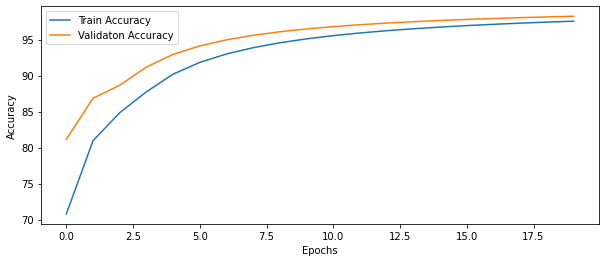

In [153]:
plt.rcParams["figure.figsize"] = (10,4)
plt.plot(train_accuracy, label = 'Train Accuracy')
plt.plot(valid_accuracy, label = 'Validaton Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [154]:
print("cnn's state_dict:")
for param_tensor in cnn.state_dict():
    print(param_tensor, "\t", cnn.state_dict()[param_tensor].size())
    
#print("Optimizer's state_dict:")
#for var_name in optimizer.cnn_dict():
#    print(var_name, "\t", optimizer.cnn_dict()[var_name])

cnn's state_dict:
conv_module.0.weight 	 torch.Size([32, 1, 3, 3])
conv_module.0.bias 	 torch.Size([32])
conv_module.3.weight 	 torch.Size([64, 32, 3, 3])
conv_module.3.bias 	 torch.Size([64])
conv_module.4.weight 	 torch.Size([64])
conv_module.4.bias 	 torch.Size([64])
conv_module.4.running_mean 	 torch.Size([64])
conv_module.4.running_var 	 torch.Size([64])
conv_module.4.num_batches_tracked 	 torch.Size([])
conv_module.7.weight 	 torch.Size([128, 64, 3, 3])
conv_module.7.bias 	 torch.Size([128])
conv_module.8.weight 	 torch.Size([128])
conv_module.8.bias 	 torch.Size([128])
conv_module.8.running_mean 	 torch.Size([128])
conv_module.8.running_var 	 torch.Size([128])
conv_module.8.num_batches_tracked 	 torch.Size([])
fc_module.0.weight 	 torch.Size([64, 768])
fc_module.0.bias 	 torch.Size([64])
fc_module.1.weight 	 torch.Size([64])
fc_module.1.bias 	 torch.Size([64])
fc_module.1.running_mean 	 torch.Size([64])
fc_module.1.running_var 	 torch.Size([64])
fc_module.1.num_batches_tracked 	

In [155]:
torch.save(cnn.state_dict(), 'G:/2020/KIST/2. code/Python/Audio/Deep Learning/Model_1/cnn_music_sheet.pt')
#cnn.load_state_dict(torch.load("G:\2020\KIST\2. code\Python\Audio\Deep Learning\Model_1"))
#cnn.eval()

In [129]:
#cnn.load_state_dict(torch.load("G:/2020/KIST/2. code/Python/Audio/Deep Learning/Model_1/cnn_music_sheet.pt"))

<All keys matched successfully>

In [29]:
#cnn.eval()

CNNClassifier(
  (conv_module): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_module): Sequential(
    (0): Linear(in_features=9856, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momen